# Peak detection using a neural network

In my PhD research, our group has been developing a new technique to study nanoparticles using mass spectrometry. Our technique allows us to continuously measure the mass of a single nanoparticle by measuring its frequency of motion in an electric field, and we are working on automating our measurements. If you are interested in the physics behind, check out https://en.wikipedia.org/wiki/Quadrupole_ion_trap

In order to measure the frequency, we do something called frequency sweeping and it can be shown below.

Let's import the necessary libraries and plot an example data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
%matplotlib inline

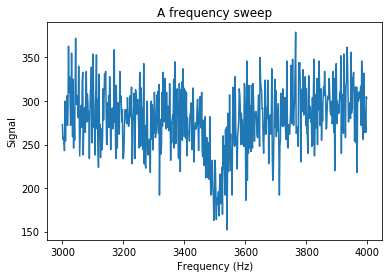

In [2]:
#reading a raw file of a frequency sweep
data = pd.read_csv("Scan 85.csv")
header = data.iloc[1] #specifying the header
data = data.iloc[2:,:] #specifying the data
data.columns=header #setting the header
#putting the data into x and y arrays. Also convert the data to float
cols = data.columns
data_x = data[cols[0]].astype(float)
data_y = data[cols[1]].astype(float)
#plot the data
plt.plot(data_x,data_y)
plt.title("A frequency sweep")
plt.ylabel("Signal")
plt.xlabel("Frequency (Hz)")
plt.show()

The figure above is showing a sweep where a "peak" (a dip in the signal) is present. We care about this because the peak indicates the particle's frequency. You can think of it as the particle responding to our measurement and giving us a peak in the signal. As the peak is not always in the frequency sweep range, it is important for us to reliably identify if the peak is present or not. 

It is not necessarily a straight forward precess to automate because of the varying background noise, peak width, peak depth, and background level affecting the performance of a simple detection algorithm. 

Enough of the details. Lets get into a machine learning approach for peak detection.

We lack labeled data and the inbalance of positive versus negative data. It may be possible that I use an anomaly detection approach, but it gets a bit tricky to train. 

To bypass these problems, I realized that it is actually easier to simulate the training data:

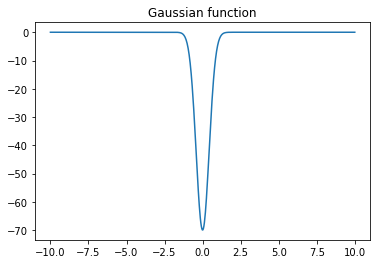

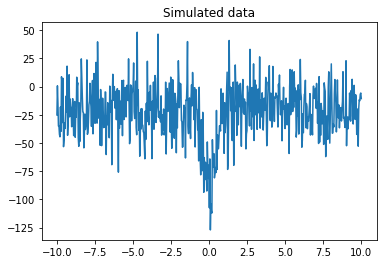

In [9]:
#simulate a gaussian peak
x = np.linspace(-10,10,600) #create an x array with 600 data points
def gaussian(x,mean,sigma,amplitude): #construct a gaussian function as a peak
    return amplitude*np.exp(-((x-mean)/sigma)**2)
y = gaussian(x,0,0.6,-70) 
plt.plot(x,y)
plt.title("Gaussian function")
plt.show()
#simulate background noise
noise = np.random.normal(-20,20,len(y)) #adding gaussian noise into the data
y_noisy = y+noise
plt.plot(x,y_noisy)
plt.title("Simulated data")
plt.show()

The simulated data looks quite similar to the real data. Now, lets generate a background without a peak present.

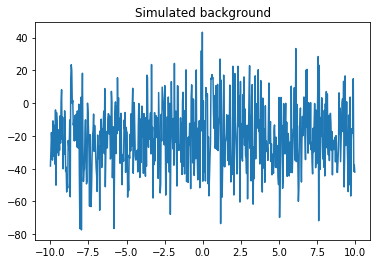

In [10]:
#simulate a baseline with noise
y_baseline = x*0
noise = np.random.normal(-20,20,len(y_baseline))
y_baseline += noise
plt.plot(x,y_baseline)
plt.title("Simulated background")
plt.show()

A function to randomly generate a scan

In [13]:
def gaussian(x,mean,sigma,amplitude):
    return amplitude*np.exp(-((x-mean)/sigma)**2)
def generate_scan(x):
    #generate gaussian curve
    mean = np.linspace(min(x),max(x),100)[random.randrange(0,99)]
    sigma = np.linspace(0.5,2,100)[random.randrange(0,99)]
    amplitude = -np.linspace(10,100,100)[random.randrange(0,99)]
    rand = random.randint(0,1)
    if  rand == 0:
        y = gaussian(x,mean,sigma,amplitude)
        peak_present = 1
    elif rand == 1:
        y = x*0
        peak_present = 0
    #generate noise
    noise_level = np.linspace(10,30,100)[random.randrange(0,99)]
    noise = np.random.normal(-noise_level,noise_level,len(y))
    y_noisy = y+noise
    return y_noisy,peak_present

Adding a function that can generate a testing set

In [14]:
#return data and label lists
def gen_dataset(x,N):
    #N is the number of data points
    data = []
    label = []
    for n in range(N):
        y, peak_present = generate_scan(x)
        data.append(y)
        label.append(peak_present)
    return np.array(data), np.array(label)
x = np.linspace(-10,10,600)
X_train, y_train = gen_dataset(x,10000)
X_test, y_test = gen_dataset(x,1000)

Train a neural network to identify peaks

In [15]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver = "lbfgs", alpha = 1E-5,
                   hidden_layer_sizes=(100,50))
clf.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Summary statistics of the testing

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       484
           1       0.97      0.89      0.93       516

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



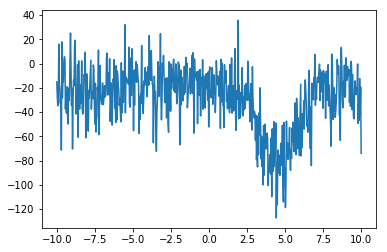

[1]
peak present?  1


In [17]:
y,peak = generate_scan(x)
plt.plot(x,y)
plt.show()
print(clf.predict(np.array([y])))
print("peak present? ", peak)

Let's make it harder for the neural network. Now I am going to add a changing baseline. 

In [18]:
def generate_scan(x):
    #generate gaussian curve
    mean = np.linspace(min(x),max(x),100)[random.randrange(0,99)]
    sigma = np.linspace(0.3,2,100)[random.randrange(0,99)]
    amplitude = -np.linspace(70,150,100)[random.randrange(0,99)]
    rand = random.randint(0,1)
    if  rand == 0:
        y = gaussian(x,mean,sigma,amplitude)
        peak_present = 1
    elif rand == 1:
        y = x*0
        peak_present = 0
    #making a random baseline
    b = np.linspace(1000,10000,100)[random.randrange(0,99)]
    m = np.linspace(-5,5,100)[random.randrange(0,99)]
    sig = np.linspace(10,20,100)[random.randrange(0,99)]
    y = y+(x*m+b)
    #generate noise
    noise_level = np.linspace(20,60,100)[random.randrange(0,99)]
    noise = np.random.normal(-noise_level,noise_level,len(y))
    y_noisy = y+noise

    return y_noisy,peak_present

Make a preprocessing function to normalize the baseline and peak

In [19]:
import statistics
def preprocess(y):
    mean = statistics.mean(y)
    std = statistics.stdev(y)
    y = (y - mean)/std
    return y

Modifying the generate scan function

In [20]:
#return data and label lists
def gen_dataset(x,N):
    #N is the number of data points
    data = []
    label = []
    for n in range(N):
        y, peak_present = generate_scan(x)
        data.append(preprocess(y))
        label.append(peak_present)
    return np.array(data), np.array(label)
X_train, y_train = gen_dataset(x,10000)
X_test, y_test = gen_dataset(x,1000)

Train a neural network on this

In [21]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver = "lbfgs", alpha = 1E-5,
                   hidden_layer_sizes=(100,50))
clf.fit(X_train,y_train)
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       491
           1       0.93      0.94      0.94       509

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



need to make a better scan generator

In [3]:
def generate_scan(x):
    #generate gaussian curve
    mean = np.linspace(min(x),max(x),100)[random.randrange(0,99)]

    rand = random.randint(0,1)
    if  rand == 0:
        peak_types = random.randint(0,2)
        if peak_types == 0: #wide frequency scan
            sigma_max, sigma_min = 0.1,0.3
            amplitude_max, amplitude_min = 200,250
        elif peak_types == 1: #mid frequency scan
            sigma_max, sigma_min = 0.5,0.7
            amplitude_max, amplitude_min = 100,200
        elif peak_types == 2: #narrow frequency scan
            sigma_max, sigma_min = 1,2
            amplitude_max, amplitude_min = 80,150
        sigma = np.linspace(sigma_max,sigma_min,100)[random.randrange(0,99)]
        amplitude = -np.linspace(amplitude_max,amplitude_min,100)[random.randrange(0,99)]
        y = gaussian(x,mean,sigma,amplitude)
        peak_present = 1
    elif rand == 1:
        y = x*0
        peak_present = 0
    #making a random baseline
    b = np.linspace(1000,10000,100)[random.randrange(0,99)]
    m = np.linspace(-5,5,100)[random.randrange(0,99)]
    sig = np.linspace(10,20,100)[random.randrange(0,99)]
    y = y+(x*m+b)
    #generate noise
    noise_level = np.linspace(20,60,100)[random.randrange(0,99)]
    noise = np.random.normal(-noise_level,noise_level,len(y))
    y_noisy = y+noise

    return y_noisy,peak_present

Retrain the neural network

In [395]:
x = np.linspace(-10,10,600)
X_train, y_train = gen_dataset(x,20000)
X_test, y_test = gen_dataset(x,1000)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver = "lbfgs", alpha = 1E-5,
                   hidden_layer_sizes=(100,50))
clf.fit(X_train,y_train)
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       474
           1       0.95      0.94      0.95       526

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



Predicting real data and simulated data

prediction (absent):  0.9999827875695224
prediction (present):  1.7212430477536478e-05
Peak is present:  0


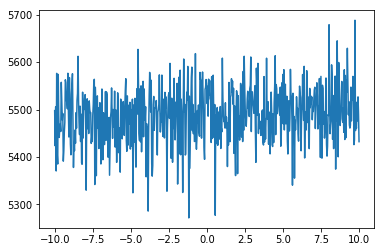

In [366]:
#simulated scan
sim_y,peak = generate_scan(x)
#real data
real_y = data_y

processed_y = preprocess(sim_y)
pred = clf.predict_proba(np.array([processed_y]))
print("prediction (absent): ", pred[0,0])
print("prediction (present): ", pred[0,1])
print("Peak is present: ", peak)
plt.plot(x,sim_y)
plt.show()

Need to save the neural network

In [396]:
import pickle
filename = "peak_mind2.pkl"
with open(filename, 'wb') as file:  
    pickle.dump(clf, file)

1


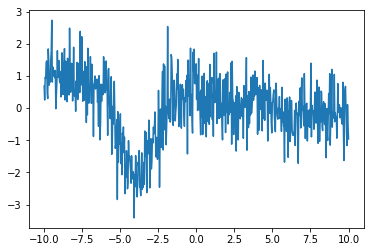

In [24]:
x = np.linspace(-10,10,600)
this,peak = generate_scan(x)
print(peak)
plt.plot(x,preprocess(this))
plt.show()

https://stackabuse.com/scikit-learn-save-and-restore-models/

Reading real data (no peak: 85,88,90,92,94,95,99,105)

prediction (absent):  0.0
prediction (present):  1.0


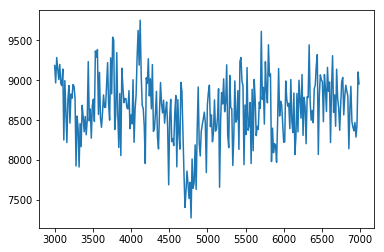

In [394]:
import pandas as pd
data = pd.read_csv("Real data\Scan 106.csv")
header = data.iloc[1]
data = data.iloc[2:,:]
data.columns=header
cols = data.columns
data_x = data[cols[0]].astype(float)
data_y = data[cols[1]].astype(float)
processed_y = preprocess(data_y)
pred = clf.predict_proba(np.array([processed_y]))
print("prediction (absent): ", pred[0,0])
print("prediction (present): ", pred[0,1])
plt.plot(data_x,data_y)
plt.show()

In [1]:
import pickle
filename = "peak_mind2.pkl"
with open(filename, 'rb') as file:  
    clf = pickle.load(file)


C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.0 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.20.0 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
